In [1]:
import pandas as pd
from sklearn import model_selection
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import torch.nn.functional as F
import os
from sklearn.metrics import roc_auc_score


In [2]:
def model_evaluate(net, test_dataloader):
    net.eval()  # 设置模型为评估模式
    y_true = []
    y_scores = []

    with torch.no_grad():
        for sample in test_dataloader:
            inputs = sample[0]
            labels = sample[1]
            labels = labels.unsqueeze(1)  # 确保标签的形状为 (batch_size, 1)
            labels = labels.float()

            # 获取模型输出，经过sigmoid后得到概率
            probabilities = torch.sigmoid(net(inputs))  # 二分类任务，输出一个概率值

            # 由于输出是一个概率，直接使用它来作为正类的概率
            y_scores.extend(probabilities.numpy())
            y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # 计算F1 Score和AUC值
    y_pred = np.round(y_scores)  # 将概率转换为0或1
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)

    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')

    # 绘制ROC曲线
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 计算99%特异性下的敏感性
    specificity = 1 - fpr
    index_99_specificity = np.argmin(np.abs(specificity - 0.99))  # 找到最接近99%特异性的索引
    sensitivity_at_99_specificity = tpr[index_99_specificity]
    print(f'Sensitivity at 99% specificity: {sensitivity_at_99_specificity}')

In [3]:
# class TEPDataset(Dataset):
#     def __init__(self, data_df, transform=None):
#         self.data_df = data_df
#         self.transform = transform

#     def __len__(self):
#         return len(self.data_df)

#     def __getitem__(self, idx):
#         row = self.data_df.iloc[idx]
#         sample = {'features': row[['bin_' + str(i) for i in range(1, 101)]].values.astype(float), 
#                   'label': row['y']}
#         if self.transform:
#             sample = self.transform(sample)
#         return sample

class ToTensor:
    def __call__(self, sample):
        features, label = sample['features'], sample['label']
        return {'features': torch.tensor(features, dtype=torch.float).unsqueeze(0),
                'label': torch.tensor(label, dtype=torch.long)}

In [4]:
class ColumnAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ColumnAttention, self).__init__()
        # 自注意力的权重
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
    
    def forward(self, x):
        # 输入 x 维度: (batch_size, 40, 13)
        Q = self.query(x)  # (batch_size, 40, hidden_dim)
        K = self.key(x)    # (batch_size, 40, hidden_dim)
        V = self.value(x)  # (batch_size, 40, hidden_dim)
        
        # 计算注意力分数: Q * K^T
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, 40, 40)
        attention_scores = attention_scores / (K.size(-1) ** 0.5)  # 缩放
        
        # 通过softmax获得注意力权重
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, 40, 40)
        
        # 应用注意力权重到值上
        attended_values = torch.matmul(attention_weights, V)  # (batch_size, 40, hidden_dim)
        return attended_values

class AttentionModel(nn.Module):
    def __init__(self, input_dim=13, seq_len=40, hidden_dim=64, output_dim=1):
        super(AttentionModel, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # 列自注意力
        self.column_attention = ColumnAttention(input_dim=input_dim, hidden_dim=hidden_dim)
        
        # 全连接层
        self.fc1 = nn.Linear(hidden_dim * seq_len, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 输入 x 维度: (batch_size, 40, 13)
        x = x.view(-1, self.seq_len, self.input_dim)  # 调整输入形状
        attention_output = self.column_attention(x)  # (batch_size, 40, hidden_dim)
        
        # 将输出展平
        attention_output = attention_output.view(-1, self.seq_len * self.hidden_dim)
        
        # 全连接层
        x = F.relu(self.fc1(attention_output))  # (batch_size, 128)
        x = self.fc2(x)  # (batch_size, output_dim)

        return x
    
    def _initialize_weights(self):
        # 对column_attention的linear层进行初始化
        init.kaiming_normal_(self.column_attention.query.weight, nonlinearity='relu')
        init.kaiming_normal_(self.column_attention.key.weight, nonlinearity='relu')
        init.kaiming_normal_(self.column_attention.value.weight, nonlinearity='relu')
        
        # 对fc1和fc2进行初始化
        init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        
        # 初始化偏置项为0
        if self.column_attention.query.bias is not None:
            init.constant_(self.column_attention.query.bias, 0)
            init.constant_(self.column_attention.key.bias, 0)
            init.constant_(self.column_attention.value.bias, 0)
        
        if self.fc1.bias is not None:
            init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            init.constant_(self.fc2.bias, 0)
    
model = AttentionModel(input_dim=13, seq_len=40, hidden_dim=64)

In [5]:
class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=None, nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if fmts is None:
            fmts = ['-', 'm--', 'g-', 'r:']
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置matplotlib的轴。"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点。"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display(self.fig)
        clear_output(wait=True)



In [6]:
class Accumulator:
    """
    在n个变量上累加
    """
    def __init__(self, n):
        self.data = [0.0] * n       # 创建一个长度为 n 的列表，初始化所有元素为0.0。

    def add(self, *args):           # 累加
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):                # 重置累加器的状态，将所有元素重置为0.0
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):     # 获取所有数据
        return self.data[idx]

In [7]:
def accuracy(y_hat, y):
    """
    计算正确的数量
    :param y_hat:
    :param y:
    :return:
    """
    # if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    #     y_hat = y_hat.argmax(axis=1)            # 在每行中找到最大值的索引，以确定每个样本的预测类别
    # cmp = y_hat.type(y.dtype) == y
    # return float(cmp.type(y.dtype).sum())
    y_hat = (y_hat >= 0.5).float()  # 将概率转化为 0 或 1
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):
    """
    计算指定数据集的精度
    :param net:
    :param data_iter:
    :return:
    """
    if isinstance(net, torch.nn.Module):
        net.eval()                  # 通常会关闭一些在训练时启用的行为
    metric = Accumulator(2)
    with torch.no_grad():
        for sample in data_iter:
            X = sample[0]
            y = sample[1]
            y_hat = net(X)
            y = y.unsqueeze(1)
            y = y.float()
            metric.add(accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """
    训练模型一轮
    :param net:是要训练的神经网络模型
    :param train_iter:是训练数据的数据迭代器，用于遍历训练数据集
    :param loss:是用于计算损失的损失函数
    :param updater:是用于更新模型参数的优化器
    :return:
    """
    if isinstance(net, torch.nn.Module):  # 用于检查一个对象是否属于指定的类（或类的子类）或数据类型。
        net.train()

    # 训练损失总和， 训练准确总和， 样本数
    metric = Accumulator(3)

    for sample in train_iter:
        X = sample[0]
        y = sample[1]
        # X = X.view(X.shape[0], 1, -1)
        y_hat = net(X)
        y = y.unsqueeze(1)
        y = y.float()
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):  # 用于检查一个对象是否属于指定的类（或类的子类）或数据类型。
            # 使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()  # 方法用于计算损失的平均值
            updater.step()
        else:
            # 使用定制（自定义）的优化器和损失函数
            l.sum().backward()
            updater(X.shape())
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]




In [8]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, scheduler = None, save_best=True, checkpoint_dir='./selfattention_checkpoints'):
    """
    训练模型
    :param net: 模型
    :param train_iter: 训练数据的迭代器
    :param test_iter: 测试数据的迭代器
    :param loss: 损失函数
    :param num_epochs: 训练的轮数
    :param updater: 参数更新器/优化器
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # 初始化动画绘制器
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    best_acc = 0.0  # 跟踪最高的测试精度
    best_epoch = 0  # 保存最佳模型的epoch
    
    for epoch in range(num_epochs):
        # 训练模型一轮，并返回训练损失和训练精度
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 计算测试集上的精度
        test_acc = evaluate_accuracy(net, test_iter)

        if save_best and test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            # 保存模型
            checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch + 1}_acc_{test_acc:.3f}.pth')
            torch.save(net.state_dict(), checkpoint_path)
            
        # 添加当前轮次的训练损失、训练精度和测试精度到动画绘制器中
        animator.add(epoch + 1, train_metrics + (test_acc,))
        if scheduler != None:
            scheduler.step()
        # 打印当前轮次的训练损失和训练精度
        print(f'Epoch {epoch + 1}, Loss {train_metrics[0]:.3f}, '
              f'Train acc {train_metrics[1]:.3f}, Test acc {test_acc:.3f}')
    # 保存训练过程的动画图像
    plt.show()
    print(f"Best Test Accuracy: {best_acc:.3f} at epoch {best_epoch + 1}")

In [25]:
def train_ch4(net, train_iter, test_iter, loss, num_epochs, updater, scheduler = None, save_best=True, checkpoint_dir='./selfattention_checkpoints_auc'):
    """
    训练模型
    :param net: 模型
    :param train_iter: 训练数据的迭代器
    :param test_iter: 测试数据的迭代器
    :param loss: 损失函数
    :param num_epochs: 训练的轮数
    :param updater: 参数更新器/优化器
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # 初始化动画绘制器
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    best_acc = 0.0  # 跟踪最高的测试精度
    best_epoch = 0  # 保存最佳模型的epoch
    best_auc =0.0
    
    for epoch in range(num_epochs):
        # 训练模型一轮，并返回训练损失和训练精度
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 计算测试集上的精度
        test_acc = evaluate_accuracy(net, test_iter)
        # 计算测试集上的AUROC
        all_labels = []
        all_preds = []
        net.eval()  # 设置模型为评估模式
        with torch.no_grad():
            for X_batch, y_batch in test_iter:
                outputs = net(X_batch)
                all_labels.append(y_batch.detach().numpy())
                all_preds.append(outputs.detach().numpy())
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        test_auc = roc_auc_score(all_labels, all_preds)

        if  test_auc > best_auc:
            best_auc = test_auc
            best_epoch = epoch
            # 保存模型
            checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch + 1}_auc_{best_auc:.3f}.pth')
            torch.save(net.state_dict(), checkpoint_path)
            
        # 添加当前轮次的训练损失、训练精度和测试精度到动画绘制器中
        animator.add(epoch + 1, train_metrics + (test_acc,))
        if scheduler != None:
            scheduler.step()
        # 打印当前轮次的训练损失和训练精度
        print(f'Epoch {epoch + 1}, Loss {train_metrics[0]:.3f}, '
              f'Train acc {train_metrics[1]:.3f}, Test acc {test_acc:.3f}')
    # 保存训练过程的动画图像
    plt.show()
    print(f"Best Test AUC: {best_auc:.3f} at epoch {best_epoch + 1}")

In [10]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # 将每个样本的 520 维特征转换为 40x13 的二维张量
        sample = self.features[idx].reshape(13, 40).astype(np.float32).T
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return torch.tensor(sample), label

In [11]:
def equal_kind(data_df):
    df_y0 = data_df[data_df['label'] == 0]
    df_y1 = data_df[data_df['label'] == 1]

    # 确定两个子集中数量较少的那个
    min_count = min(len(df_y0), len(df_y1))

    # 从两个子集中随机选择等量的样本
    df_y0_balanced = df_y0.sample(n=min_count, random_state=42) if len(df_y0) > min_count else df_y0
    df_y1_balanced = df_y1.sample(n=min_count, random_state=42) if len(df_y1) > min_count else df_y1

    # 合并这两个平衡后的子集
    balanced_df = pd.concat([df_y0_balanced, df_y1_balanced])
    # 打乱合并后的数据集的顺序
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

In [12]:
# 合并所有样本
folder_path = '/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/resources/SelfAttentionSamples/labels/'

# 获取该文件夹下所有 CSV 文件的文件名，并按文件名顺序排序
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# 创建一个空的列表，用于存储所有的 DataFrame
dfs = []

# 依次读取每个 CSV 文件并将其添加到列表中
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV 文件
    dfs.append(df)  # 将 DataFrame 添加到列表中

# 将所有的 DataFrame 按列合并
y_df = pd.concat(dfs, axis=0)

# 设置文件夹路径
folder_path = '/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/resources/SelfAttentionSamples/samples/'
# 获取该文件夹下所有 CSV 文件的文件名，并按文件名顺序排序
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
# 创建一个空的列表，用于存储所有的 DataFrame
dfs = []
# 依次读取每个 CSV 文件并将其添加到列表中
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV 文件
    dfs.append(df)  # 将 DataFrame 添加到列表中
# 将所有的 DataFrame 按列合并
X_df = pd.concat(dfs, axis=0)

merged_df = pd.merge(X_df, y_df, on='sample', how='left')
merged_df = equal_kind(merged_df)
# 将特征列转换为 NumPy 数组，并将标签列提取出来
features = merged_df.iloc[:, 1:-1].values  # 第一列为 'sample'，最后一列为 'label'
labels = merged_df.iloc[:, -1].values  # 标签列

dataset = CustomDataset(features, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 100, Loss 0.001, Train acc 0.975, Test acc 0.789


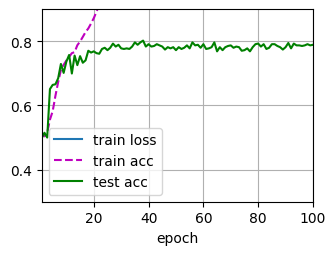

Best Test Accuracy: 0.802 at epoch 38


In [ ]:
model._initialize_weights()

num_epochs = 100
loss = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_ch3(model, train_loader, test_loader, loss, num_epochs, optimizer) #, scheduler)

F1 Score: 0.8065693430656934
AUC: 0.8501475829806193


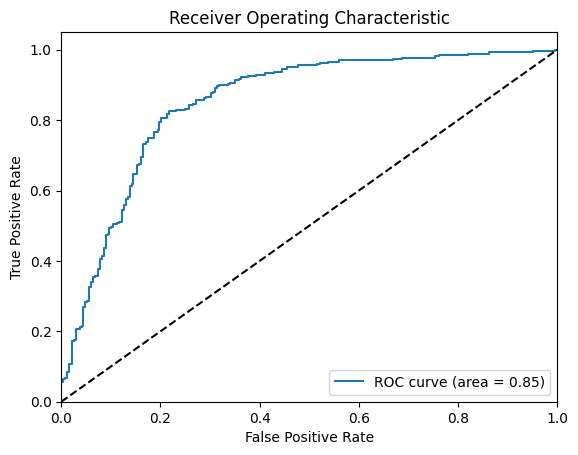

Sensitivity at 99% specificity: 0.06716417910447761


In [16]:
# 加载最佳模型
best_model_path = os.path.join('/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/full_sample_test/selfattention_checkpoints/best_model_epoch_38_acc_0.802.pth')
model.load_state_dict(torch.load(best_model_path))
model.eval()  # 切换为评估模式
model_evaluate(model, test_loader)


Epoch 100, Loss 0.012, Train acc 0.824, Test acc 0.757


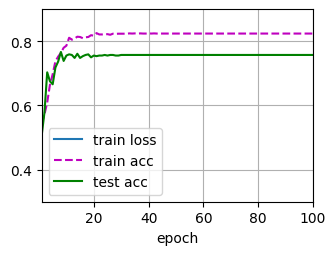

Best Test Accuracy: 0.767 at epoch 8


In [11]:
model._initialize_weights()

num_epochs = 100
loss = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_ch3(model, train_loader, test_loader, loss, num_epochs, optimizer, scheduler)

F1 Score: 0.7835820895522388
AUC: 0.8460403207841389


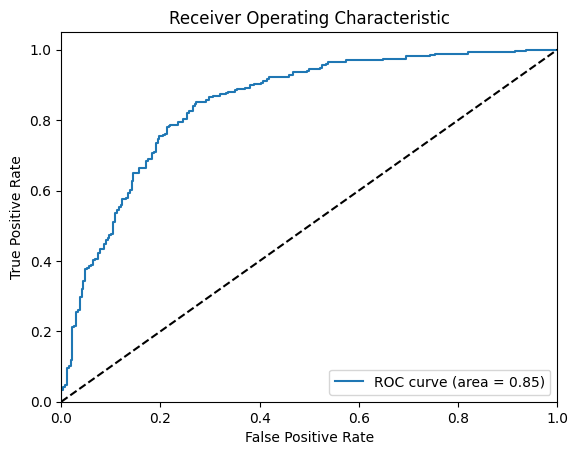

Sensitivity at 99% specificity: 0.048507462686567165


In [12]:
model_evaluate(model, test_loader)

Epoch 100, Loss 0.003, Train acc 0.980, Test acc 0.780


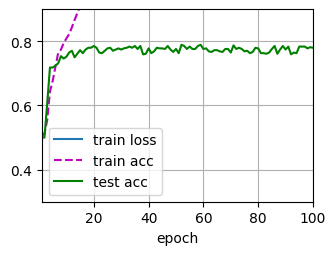

Best Test Accuracy: 0.789 at epoch 52


In [14]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model._initialize_weights()

num_epochs = 100
loss = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_ch3(model, train_loader, test_loader, loss, num_epochs, optimizer)#, scheduler)

F1 Score: 0.8014705882352942
AUC: 0.8569489307195366


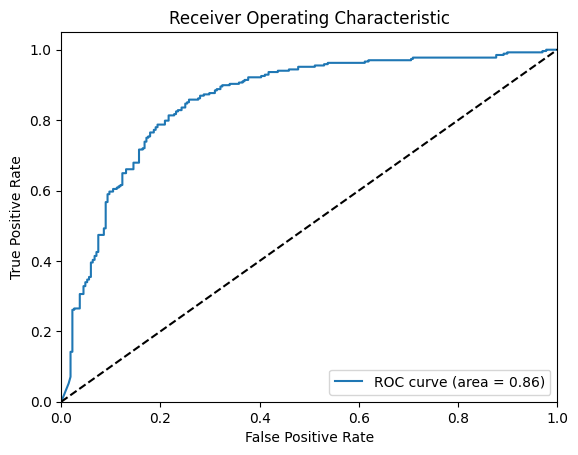

Sensitivity at 99% specificity: 0.05223880597014925


In [ ]:
# 加载最佳模型
best_model_path = os.path.join('/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/full_sample_test/selfattention_checkpoints/best_model_epoch_52_acc_0.789.pth')
model.load_state_dict(torch.load(best_model_path))
model.eval()  # 切换为评估模式
model_evaluate(model, test_loader)

Epoch 100, Loss 0.002, Train acc 0.980, Test acc 0.784


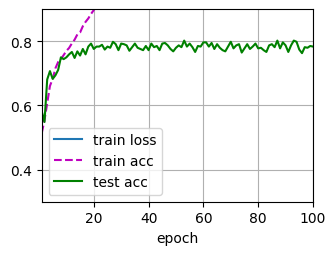

Best Test AUC: 0.870 at epoch 72


In [27]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model._initialize_weights()

num_epochs = 100
loss = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
train_ch4(model, train_loader, test_loader, loss, num_epochs, optimizer, checkpoint_dir='./selfattention_32,32,nosch,lr0.001')

F1 Score: 0.7955390334572491
AUC: 0.8698972488304746


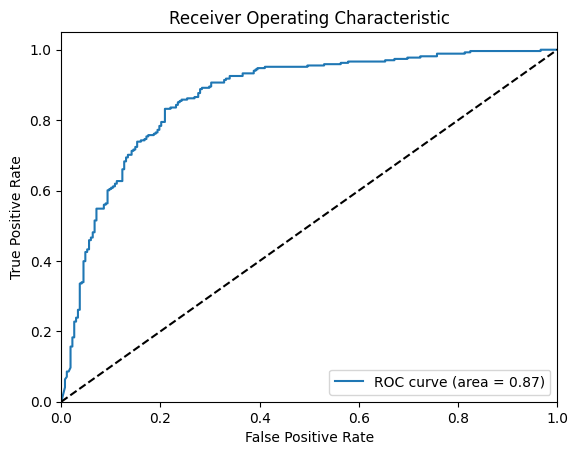

Sensitivity at 99% specificity: 0.0708955223880597


In [28]:
# 加载最佳模型
best_model_path = os.path.join('/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/full_sample_test/selfattention_32,32,nosch,lr0.001/best_model_epoch_72_auc_0.870.pth')
model.load_state_dict(torch.load(best_model_path))
model.eval()  # 切换为评估模式
model_evaluate(model, test_loader)